#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite Difference methods in 2 dimensions

Let's start by generalizing the 1D Laplacian,

\begin{align} - u''(x) &= f(x) \text{ on } \Omega = (a,b) & u(a) &= g_0(a) & u'(b) = g_1(b) \end{align}

to two dimensions

\begin{align} -\nabla\cdot \big( \nabla u(x,y) \big) &= f(x,y) \text{ on } \Omega \subset \mathbb R^2
& u|_{\Gamma_D} &= g_0(x,y) & \nabla u \cdot \hat n|_{\Gamma_N} &= g_1(x,y)
\end{align}

where $\Omega$ is some well-connected open set (we will assume simply connected) and the Dirichlet boundary $\Gamma_D \subset \partial \Omega$ is nonempty.

We need to choose a system for specifying the domain $\Omega$ and ordering degrees of freedom.  Perhaps the most significant limitation of finite difference methods is that this specification is messy for complicated domains.  We will choose
$$ \Omega = (0, 1) \times (0, 1) $$
and
\begin{align} (x, y)_{im+j} &= (i h, j h) & h &= 1/(m-1) & i,j \in \{0, 1, \dotsc, m-1 \} .
\end{align}

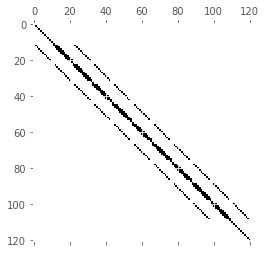

In [18]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def laplacian2d_dense(h, f, g0):
    m = int(1/h + 1)
    c = numpy.linspace(0, 1, m)
    x, y = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    A = numpy.zeros((m*m, m*m))
    def idx(i, j):
        return i*m + j
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            if i in (0, m-1) or j in (0, m-1):
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                cols = [idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]]
                stencil = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])
                A[row, cols] = stencil
    return x, y, A, rhs

x, y, A, rhs = laplacian2d_dense(.1, lambda x,y: 0*x+1, lambda x,y: 0*x)

pyplot.spy(A);

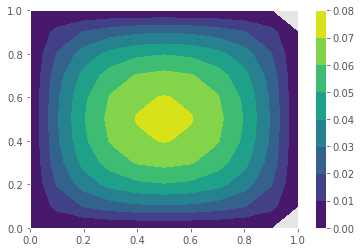

In [20]:
u = numpy.linalg.solve(A, rhs).reshape(x.shape)

pyplot.contourf(x, y, u)
pyplot.colorbar();

In [29]:
import cProfile
prof = cProfile.Profile()
prof.enable()
x, y, A, rhs = laplacian2d_dense(.02, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = numpy.linalg.solve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         19525 function calls in 0.261 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.227    0.227    0.227    0.227 linalg.py:300(solve)
        1    0.022    0.022    0.033    0.033 <ipython-input-18-ad069d7c8741>:6(laplacian2d_dense)
     2411    0.004    0.000    0.004    0.000 {built-in method numpy.core.multiarray.array}
     2401    0.003    0.000    0.005    0.000 <ipython-input-18-ad069d7c8741>:22(<listcomp>)
    14606    0.002    0.000    0.002    0.000 <ipython-input-18-ad069d7c8741>:13(idx)
        2    0.001    0.000    0.001    0.000 {method 'copy' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 <ipython-input-29-eac89f9bd984>:4(<lambda>)
        3    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        1    0.000    0.000    0.033    0.033 <ipython-input-29-eac89f9bd984>:4(<module>)
        1    0.000    0.000    0.000    0.000 function_base.py:

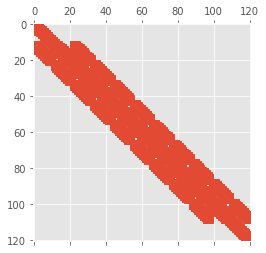

In [45]:
import scipy.sparse as sp
import scipy.sparse.linalg

def laplacian2d(h, f, g0):
    m = int(1/h + 1)
    c = numpy.linspace(0, 1, m)
    x, y = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    A = sp.lil_matrix((m*m, m*m))
    def idx(i, j):
        return i*m + j
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            if i in (0, m-1) or j in (0, m-1):
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                cols = [idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]]
                stencil = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])
                A[row, cols] = stencil
    return x, y, A.tocsr(), rhs

x, y, A, rhs = laplacian2d(.1, lambda x,y: 0*x+1, lambda x,y: 0*x)

pyplot.spy(A);

In [46]:
prof = cProfile.Profile()
prof.enable()
x, y, A, rhs = laplacian2d(.002, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         33390366 function calls in 28.801 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   996006    4.640    0.000    6.334    0.000 stride_tricks.py:115(_broadcast_to)
        1    2.933    2.933    2.933    2.933 {built-in method scipy.sparse.linalg.dsolve._superlu.gssv}
        1    2.113    2.113   25.831   25.831 <ipython-input-45-767daafd3ba5>:4(laplacian2d)
  2988037    2.090    0.000    2.090    0.000 {built-in method numpy.core.multiarray.array}
   249001    1.684    0.000    1.684    0.000 {scipy.sparse._csparsetools.lil_fancy_set}
   251001    1.550    0.000   22.083    0.000 lil.py:333(__setitem__)
   498003    1.340    0.000   10.137    0.000 stride_tricks.py:195(broadcast_arrays)
   249001    1.039    0.000   10.200    0.000 sputils.py:351(_index_to_arrays)
   498003    0.961    0.000    1.021    0.000 stride_tricks.py:176(_broadcast_shape)
   498002    0.926    0.000    2.058    0.000 sputils.py:331(_chec